<a href="https://colab.research.google.com/github/aist1110-2020R1/lecture11/blob/main/CNN_visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras
import numpy as np

tf.keras.__version__

'2.4.0'

In [ ]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 3, 3, 64)          36928     
Total params: 55,744
Trainable params: 55,744
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_2 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)               

In [ ]:
from keras.datasets import mnist
from keras.utils import to_categorical

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# shuffle the data
idx_perm = np.random.RandomState(101).permutation(train_images.shape[0])
train_images, train_labels = train_images[idx_perm], train_labels[idx_perm]

train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype('float32') / 255

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

In [ ]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(train_images, train_labels, epochs=5, batch_size=64)

Epoch 1/5
938/938 [==============================] - 3s 4ms/step - loss: 0.1778 - accuracy: 0.9450
Epoch 2/5
938/938 [==============================] - 3s 4ms/step - loss: 0.0455 - accuracy: 0.9859
Epoch 3/5
938/938 [==============================] - 3s 3ms/step - loss: 0.0310 - accuracy: 0.9904
Epoch 4/5
938/938 [==============================] - 4s 4ms/step - loss: 0.0244 - accuracy: 0.9927
Epoch 5/5
938/938 [==============================] - 4s 4ms/step - loss: 0.0191 - accuracy: 0.9940


In [ ]:
test_loss, test_acc = model.evaluate(test_images, test_labels)

313/313 [==============================] - 1s 3ms/step - loss: 0.0316 - accuracy: 0.9915


In [ ]:
test_acc

0.9915000200271606

8
8


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


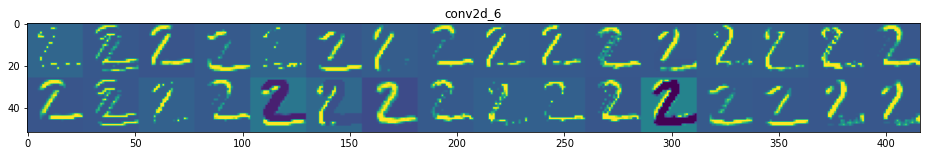

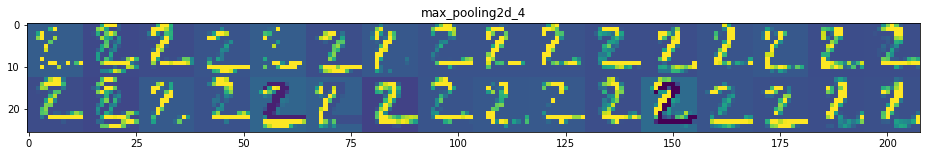

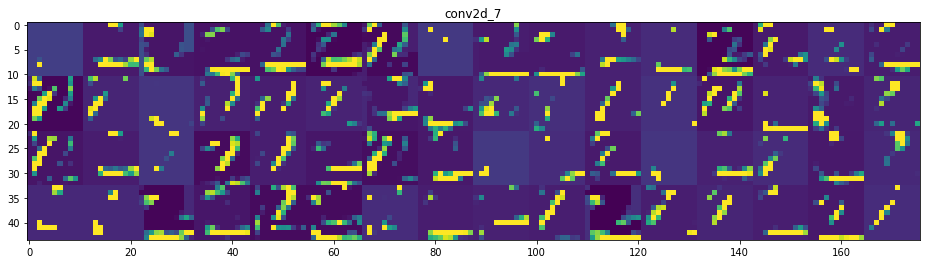

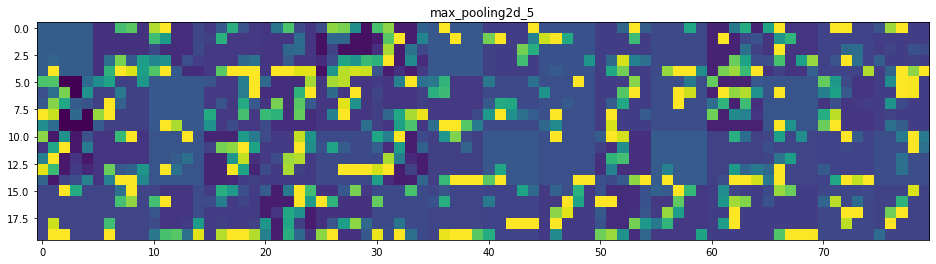

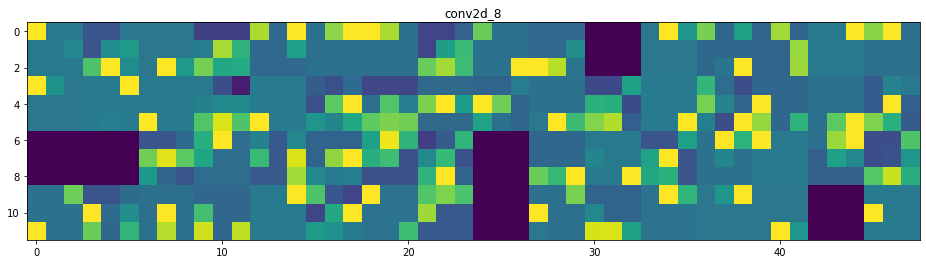

In [ ]:
layer_outputs = [layer.output for layer in model.layers]
print(len(layer_outputs))

activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(test_images)
print(len(activations))

layer_names = [] 
for layer in model.layers[:5]:
    layer_names.append(layer.name)

images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[1, :, :, col * images_per_row + row]
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8') 
            display_grid[col * size : (col + 1) * size, 
			             row * size : (row + 1) * size] = channel_image

    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1], 
	                    scale * display_grid.shape[0])) 
    plt.title(layer_name) 
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

# It's normal that the above code may generate "RuntimeWarning: invalid value 
# encountered in true_divide" because channel_image.std() may be zero, which 
# means the channel was not activated.

There are a few things to note here:
*   The first layer acts as a collection of various edge detectors. At that stage, the activations retain almost all of the information present in the initial picture.
*   As you go deeper into the network, the activations become increasingly abstract and less visually interpretable. They begin to encode higher-level features, e.g. whether a particular pattern is found.
*   Higher-level presentations carry increasingly less information about the visual contents of the image, and increasingly more information related to the class of the image.
*   More "blank images" are found in deeper layers, which mean no activations. The sparsity of the activations increases with the depth of the layer: in the first layer, all or most filters are activated by the input image; but in the successive layers, more and more filters are blank. This means the pattern encoded by the filter isn't found in the input image. 

(You may try the "cats vs dogs" dataset; these phenomena would be even more obvious.)